In [31]:
import math
import numpy as np
from botorch.utils import t_batch_mode_transform
import torch
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models import  SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.monte_carlo import AcquisitionFunction
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.optim.initializers import gen_batch_initial_conditions
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms.outcome import Standardize

#kernels
from gpytorch.kernels import RBFKernel, MaternKernel, LinearKernel, ScaleKernel

problem setting

caco data set

In [32]:

from botorch.utils.sampling import draw_sobol_samples
target = torch.load('caco_target.pt')
domain = torch.load('caco_domain.pt')


import random
def test_f(X: torch.Tensor, tensor: torch.Tensor) -> int:
    # Compare the 1*d tensor (row) with each row in the n*d tensor
    matches = (tensor == X).all(dim=1)
    
    # Find the index of the matching row
    match_idx = torch.where(matches)[0][-1]
    # If a match is found, return the index
    
    return match_idx.item()

    # Stack the list of rows into a tensor and return it
    output = torch.stack(output_rows)
    return output
def generate_initial_data(n):
    # generate training data
    ind = random.sample(range(target.shape[0]), n)
    return ind

ub = torch.max(domain, dim=0)[0]
lb = torch.min(domain,dim = 0)[0]

d = domain.shape[1]

In [33]:
target.shape

torch.Size([909, 3])

acquisition

In [34]:
from botorch.acquisition import AnalyticAcquisitionFunction
import torch

class HyperVolumeScalarizedUCB(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model,
        beta: float,
        theta: torch.Tensor,
        ref: torch.Tensor,
        maximize: bool = True,
    ) -> None:
        """
        Initializes the HyperVolume Scalarized Upper Confidence Bound Acquisition Function.

        Args:
            model: A BoTorch model representing the posterior distribution of the objectives.
            beta (Tensor of shape [1] or [o]): The exploration-exploitation trade-off parameter(s).
            theta (Tensor of shape [o]): The weights used for scalarizing the upper bounds, where `o` is the number of objectives.
            maximize (bool): Whether to maximize or minimize the scalarized objective. Defaults to True (maximize).
        """
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("theta", torch.as_tensor(theta))
        self.register_buffer("ref", torch.as_tensor(ref))
    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the scalarized Upper Confidence Bound on the candidate set X.

        Args:
            X (Tensor of shape [b, d]): A tensor containing `(b)` batches of `d`-dimensional design points.

        Returns:
            Tensor of shape [b]: A tensor containing the scalarized Upper Confidence Bound values for each batch.
        """
        self.beta = self.beta.to(X)
        self.theta = self.theta.to(X)
        self.ref = self.ref.to(X)
        posterior = self.model.posterior(X)
        means = posterior.mean.squeeze(dim=-2)  # b x o
        std_devs = posterior.variance.squeeze(dim=-2).sqrt()  # b x o
        m = means.shape[1]
        # Calculate upper confidence bounds for each objective
        u_t = means + (self.beta.expand_as(means) * std_devs) - self.ref # b x o

        # Apply the scalarization function to the upper bounds
        scalarized_ut = torch.min(torch.max(torch.zeros_like(u_t), u_t / self.theta) ** m, dim=-1)[0]  # b

        return scalarized_ut


Auxiliary Acq

In [35]:
class AuxiliaryAcq(MCAcquisitionFunction):
    def __init__(
        self,
        model,
        beta: float,
        theta: torch.Tensor,
        ref: torch.Tensor,
        maximize: bool = True,
    ) -> None:
        """
        An auxiliary acquisition defined in Algo.2

        Args:
            model: A BoTorch model representing the posterior distribution of the objectives.
            beta (Tensor of shape [1] or [o]): The exploration-exploitation trade-off parameter(s).
            theta (Tensor of shape [o]): The weights used for scalarizing the upper bounds, where `o` is the number of objectives.
            maximize (bool): Whether to maximize or minimize the scalarized objective. Defaults to True (maximize).
        """
        super(MCAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("theta", torch.as_tensor(theta))
        self.register_buffer("ref", torch.as_tensor(ref))
    @t_batch_mode_transform()
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the scalarized Upper Confidence Bound on the candidate set X.

        Args:
            X (Tensor of shape [b, d]): A tensor containing `(b)` batches of `d`-dimensional design points.

        Returns:
            Tensor of shape [b]: A tensor containing the scalarized Upper Confidence Bound values for each batch.
        """
        self.beta = self.beta.to(X)
        self.theta = self.theta.to(X)
        self.ref = self.ref.to(X)
        posterior = self.model.posterior(X)
        #print(posterior.mean.shape)
        means = posterior.mean  # b x q x o
        std_devs = posterior.variance.sqrt()  # b x q x o
        # Calculate upper confidence bounds for each objective
        u_t = means + (self.beta.expand_as(means) * std_devs) - self.ref # b x qx o
        #print('233', u_t.shape)

        # Apply the scalarization function to the upper bounds
        scalarized_ut = torch.min(torch.min(u_t, dim=-1)[0], dim=-1)[0]  # b
        return scalarized_ut


constraints

In [36]:
import torch
from typing import List, Tuple, Callable

def create_ucb_constraints(model, beta: float, thresholds: torch.Tensor):
    """
    Creates a list of non-linear inequality constraints for a multi-output GP model, ensuring that the upper confidence
    bounds of the model's outputs are greater than or equal to the specified thresholds.

    Args:
        model (MultiTaskGP): A multi-output Gaussian Process model.
        beta (float): The scalar coefficient for the variance component of the UCB.
        thresholds (torch.Tensor): A tensor of thresholds for each output dimension.

    Returns:
        List[Tuple[Callable, bool]]: A list of tuples, each containing a callable constraint and a boolean indicating
                                      whether the constraint is intra-point (True) or inter-point (False). Each callable
                                      takes a tensor `X` of shape [q, d] (where `d` is the dimension of the input space
                                      and `q` can be 1 or more representing different design points) and returns a scalar
                                      that should be non-negative if the constraint is satisfied.
    """
    
    def constraint(X):
        """
        Evaluates all constraints for a batch of design points.

        Args:
            X (torch.Tensor): A tensor of shape [q, d] (where `d` is the dimension of the input space and `q` can be 1 or more 
                              representing different design points).

        Returns:
            torch.Tensor: A tensor of shape [q, m] (where `m` is the number of output dimensions) containing the evaluated 
                          constraints.
        """
        # Compute posterior at X
        X = X.unsqueeze(0)
        posterior = model.posterior(X)
        mean = posterior.mean
        variance = posterior.variance
        ucb = mean + beta * variance.sqrt()  # Compute the UCB

        # Evaluate all constraints and return the difference from thresholds
        return ucb - thresholds

    # Create a list of constraints for each output dimension, all set as intra-point since they evaluate individually
    constraints = [(lambda X, i=i: constraint(X)[:, i], True) for i in range(thresholds.size(0))]

    return constraints


In [37]:
def get_random_sample_on_n_sphere(N, R):
    # Return a single sample of a vector of dimension N
    # with a uniform distribution on the (N-1)-Sphere surface of radius R.
    # RATIONALE: https://mathworld.wolfram.com/HyperspherePointPicking.html
    
    # Generate a normally distributed point
    X = torch.randn(N)

    # Normalize this point to the surface of the sphere, then scale by radius R
    return R * X / torch.norm(X)

BO loop

take thresholds to be: -1.9, -2.25

kernel picking

In [38]:
from metrics import HV, violation
from gauche.kernels.fingerprint_kernels.tanimoto_kernel import TanimotoKernel
base = TanimotoKernel()
covar_module = ScaleKernel(
base_kernel=base,
)

In [39]:
import warnings

warnings.filterwarnings('ignore')
import time
c = 0
noise = 0.005
print('0'*50)
random_seeds = [83810, 14592, 3278, 97196, 36048, 32098, 29256, 18289, 96530, 13434, 88696, 97080, 71482, 11395, 77397, 55302, 4165, 3905, 12280, 28657, 30495, 66237, 78907, 3478, 73563,
26062, 93850, 85181, 91924, 71426, 54987, 28893, 58878, 77236, 36463, 851, 99458, 20926, 91506, 55392, 44597, 36421, 20379, 28221, 44118, 13396, 12156, 49797, 12676, 47052]
declared = False
for seed in random_seeds[:10]:
    target = torch.load('caco_target.pt')
    domain = torch.load('caco_domain.pt')
    torch.manual_seed(seed)
    ind = generate_initial_data(64)
    c+=1
    torch.save(ind, f'ind_{c}.pt')
    continue
    train_X = domain[ind,:]
    train_Y = target[ind, :]
    train_Xr = domain[ind,:]
    train_Yr = target[ind, :]
    '''mask = [True]*target.shape[0]
    mask[tuple(ind)] = False
    target = target[mask,:]
    domain = domain[mask,:]'''
    thresholds = torch.tensor([0.5, 80, -5], dtype= torch.float64)
    Hpv = []
    Hpvr = []
    Acq = []
    print(f'round:0 {HV(Y = train_Y, ref = thresholds)}')
    NUM_ITER = 60
    for batch in range(NUM_ITER):
        # model_list = []
        # m = 3
        # for i in range(m):
        #     current_model = SingleTaskGP(train_X= train_X, train_Y= train_Y[:, i].unsqueeze(-1), outcome_transform= Standardize(m = 1), train_Yvar= torch.zeros((train_X.shape[0],1)) + noise**2, covar_module= covar_module)
        #     model_list.append(current_model)
        # model = ModelListGP(*model_list)
        # mll = SumMarginalLogLikelihood(model.likelihood, model)
        # fit_gpytorch_mll(mll)
        # #t1 = time.monotonic()
        # #sample theta from distribution
        # theta = get_random_sample_on_n_sphere(m,1).abs()
        # beta = 0.15 * math.log(1+batch)
        # beta_const = beta

        # #auxiliary acquisition
        # def const(X):
        #     posterior = model.posterior(X)
        #     mean = posterior.mean
        #     variance = posterior.variance
        #     ucb_const = mean + beta_const * variance.sqrt()
        #     ucb_const = ucb_const
        #     return ucb_const
        # vio = violation(const(domain), thresholds)
        # feasi_ind = (vio == 0)

        # #t2 = time.monotonic()
        # #create acquisition function
        # HVUCB = HyperVolumeScalarizedUCB(model= model, beta= torch.tensor(beta), theta = theta, ref= thresholds)
        # #optimize constraint function
        # candidate, acq_scalar = optimize_acqf_discrete(
        #     acq_function = HVUCB,
        #     q = 1,
        #     choices = domain[feasi_ind,:]
        # )
        candidater = domain[random.sample(range(target.shape[0]), 1)[0],:].unsqueeze(0)
        #t3 = time.monotonic()
        #update data
        # train_X = torch.cat([train_X, candidate],dim=0)
        # train_Y = torch.cat([train_Y, target[test_f(candidate, domain),:].unsqueeze(0)], dim = 0)
        train_Xr = torch.cat([train_Xr, candidater],dim=0)
        train_Yr = torch.cat([train_Yr, target[test_f(candidater, domain),:].unsqueeze(0)], dim = 0)
        # hv = HV(Y = train_Y, ref = thresholds)
        hvr = HV(Y = train_Yr, ref = thresholds)
        # print(f'round: {batch+1}', hv, test_f(candidate, domain), hvr)
        # Hpv.append(hv)
        Hpvr.append(hvr)
        # Acq.append(acq_scalar)
        ###prune candidate###
        mask = torch.tensor([True]*target.shape[0])
        mask[test_f(candidater, domain)] = False
        domain = domain[mask, :]
        target = target[mask, :]
        ####################
    if not declared:
        c+=1
        # torch.save(torch.tensor(Hpv), f'hv_caco_0.15_{c}.pt')
        # torch.save(torch.tensor(Hpvr), f'hv_random_caco_0.15_{c}.pt')
        # torch.save(train_Y, f'obj_caco_0.15_{c}.pt')
        torch.save(train_Yr, f'obj_caco_rand_{c}.pt')
        print('o', end='')
    else:
        print('*', end='')
    declared = False

00000000000000000000000000000000000000000000000000


demonstration

NameError: name 'train_Y' is not defined

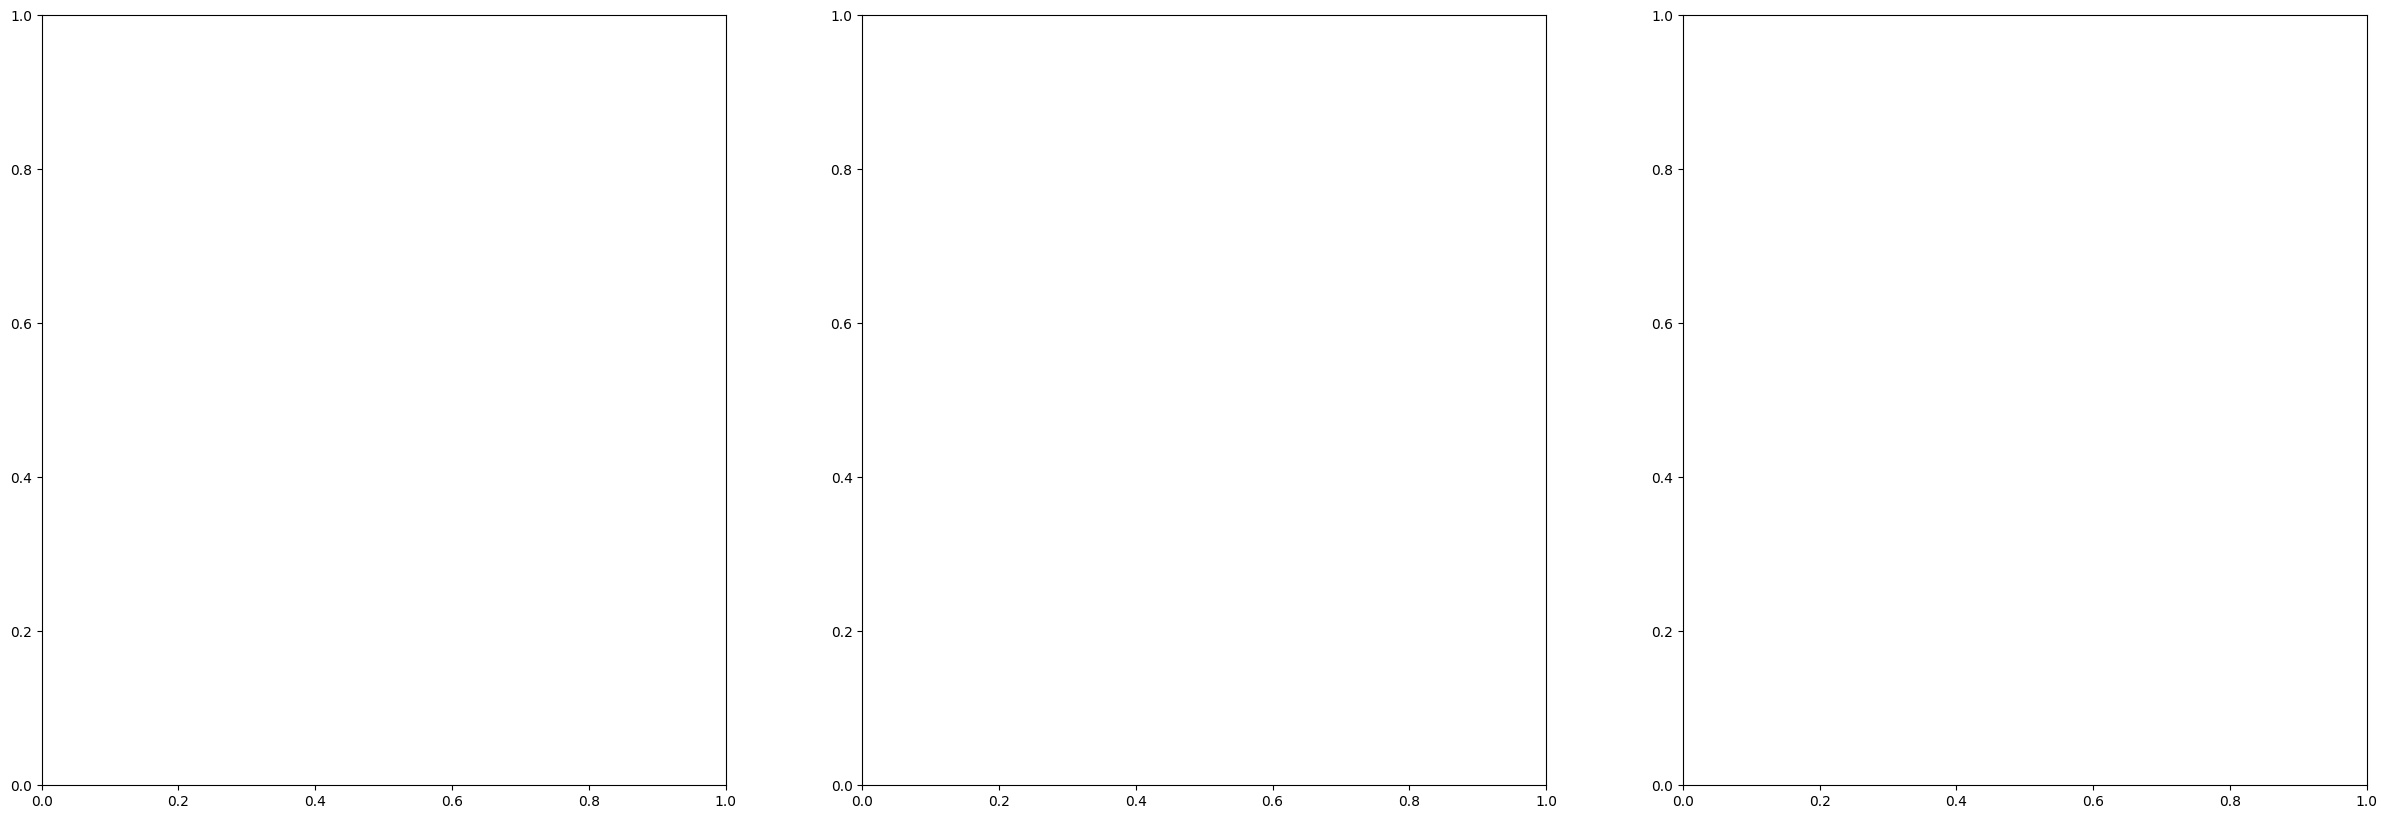

In [40]:
import matplotlib.pyplot as plt
pairs = [[0,1], [0,2], [1,2]]
thresholds = [0.5, 80, -5]
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i,pair in enumerate(pairs):
    m = pair[0]
    n= pair[1]
    ax[i].scatter(train_Y[:64,m], train_Y[:64,n], s = 1,c = 'green')
    ax[i].scatter(train_Y[65:,m], train_Y[65:,n], s = 1, c = 'blue')
    ax[i].scatter(target[:,m], target[:,n], s = 0.5, c = 'pink', alpha = 0.5)
    ax[i].plot([thresholds[m],thresholds[m]+0.5*thresholds[m]], [thresholds[n],thresholds[n]], c = 'red')
    ax[i].plot([thresholds[m],thresholds[m]], [thresholds[n],thresholds[n]+0.5*abs(thresholds[n])], c = 'red')


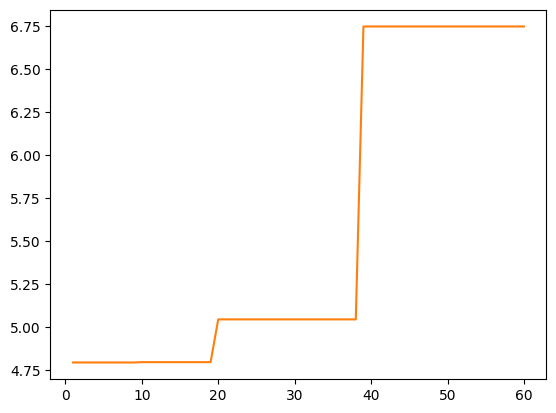

In [20]:
plt.plot(range(1, len(Hpv)+1), Hpv)
plt.plot(range(1, len(Hpvr)+1), Hpvr)

In [21]:
with torch.no_grad():    
    mean = model.posterior(domain).mean
pairs = [[0,1], [0,2], [1,2]]
thresholds = [0.5, 80, -5]
fig, ax = plt.subplots(1,3, figsize = (30,10))
for i,pair in enumerate(pairs):
    m = pair[0]
    n= pair[1]
    ax[i].scatter(mean[:,m], mean[:,n], s = 1,c = 'green')
    ax[i].scatter(target[:,m], target[:,n], s = 0.5, c = 'pink', alpha = 0.5)
    ax[i].plot([thresholds[m],thresholds[m]+0.5*thresholds[m]], [thresholds[n],thresholds[n]], c = 'red')
    ax[i].plot([thresholds[m],thresholds[m]], [thresholds[n],thresholds[n]+0.5*abs(thresholds[n])], c = 'red')


NameError: name 'model' is not defined

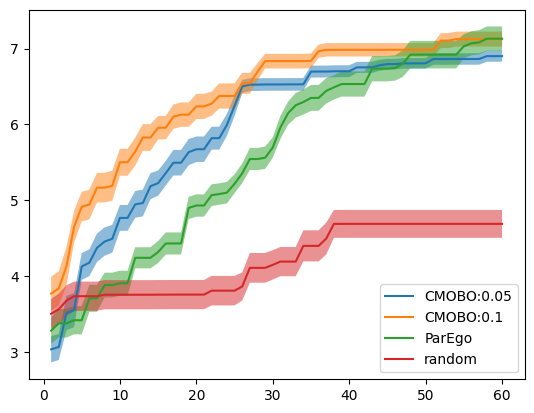

In [ ]:
N = 10
data = torch.zeros((N,60))
data_01 = torch.zeros((N,60))
data_qpar = torch.zeros((N,60))
data_r = torch.zeros((N,60))
for i in range(N):
    data[i,:] = torch.load(f'hv_caco_0.05{i+1}.pt')
    data_01[i,:] = torch.load(f'hv_caco_0.1_{i+1}.pt')
    data_qpar[i,:] = torch.load(f'hv_qparego_caco_{i+1}.pt')[1:]
    data_r[i,:] = torch.load(f'hv_random_caco_0.1_{i+1}.pt')
mean = data.mean(dim = 0)
std = data.std(dim = 0)
mean_01 = data_01.mean(dim = 0)
std_01 = data_01.std(dim = 0)
mean_qpar = data_qpar.mean(dim = 0)
std_qpar = data_qpar.std(dim = 0)
mean_r = data_r.mean(dim = 0)
std_r = data_r.std(dim = 0)
plt.plot(range(1,1+len(mean)), mean)
plt.plot(range(1,1+len(mean_01)), mean_01)
plt.plot(range(1,1+len(mean_qpar)), mean_qpar)
plt.plot(range(1,1+len(mean_r)), mean_r)
plt.legend(['CMOBO:0.05', 'CMOBO:0.1', 'ParEgo', 'random'])
plt.fill_between(range(1,1+len(mean)), mean + 0.1 *std, mean - 0.1 *std, alpha = 0.5)
plt.fill_between(range(1,1+len(mean_01)), mean_01 + 0.1 *std_01, mean_01 - 0.1 *std_01, alpha = 0.5)
plt.fill_between(range(1,1+len(mean_qpar)), mean_qpar + 0.1 *std_qpar, mean_qpar - 0.1 *std_qpar, alpha = 0.5)
plt.fill_between(range(1,1+len(mean_r)), mean_r + 0.1 *std_r, mean_r - 0.1 *std_r, alpha = 0.5)

In [ ]:
random_seeds[:10]